# Анализ данных для интерент-магазина

В данном проекте мы анализируем показатели крупного интернет-магазина.  
Нам предстои приоритизировать имеющиеся гиоптезы, а также провести анализ результатов A/B теста.  

Для анализа нам доступны следующие данные:  
Данные для приоритизации гипотез:   
Файл /datasets/hypothesis.csv  
* Hypothesis — краткое описание гипотезы;  
* Reach — охват пользователей по 10-балльной шкале;  
* Impact — влияние на пользователей по 10-балльной шкале;  
* Confidence — уверенность в гипотезе по 10-балльной шкале;  
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

Данные для анализа A/B теста:  
Файл /datasets/orders.csv  
* transactionId — идентификатор заказа;  
* visitorId — идентификатор пользователя, совершившего заказ;  
* date — дата, когда был совершён заказ;  
* revenue — выручка заказа;  
* group — группа A/B-теста, в которую попал заказ.  

Файл /datasets/visitors.csv   
* date — дата;  
* group — группа A/B-теста;  
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста  

In [55]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Загрузка и предобработка данных

In [57]:
#В проекте использован датасет предоставленный Яндекс.Практикум
hypothesis = pd.read_csv('/***/***.csv')

In [58]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 

In [59]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Запишем названия колонок в нижнем регистре для удобства

In [60]:
hypothesis.columns = hypothesis.columns.str.lower()

In [61]:
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [62]:
#В проекте использован датасет предоставленный Яндекс.Практикум
orders = pd.read_csv('/***/***.csv')

In [63]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [64]:
orders.columns = orders.columns.str.lower()

In [65]:
len(orders)

1197

In [66]:
orders.isnull().mean()

transactionid    0.0
visitorid        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

In [67]:
orders.duplicated().sum()

0

Пропусков и дубликатов нет

In [68]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionid    1197 non-null int64
visitorid        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Дату нужно перевести в формат даты

In [69]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [70]:
#В проекте использован датасет предоставленный Яндекс.Практикум
visitors=pd.read_csv('/***/***.csv')

In [71]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [72]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [73]:
visitors.duplicated().sum()

0

пропусков и дубликатов нет, переведём дату в формат даты

In [74]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Проверим есть ли пользователи, которые попали в обе группы

In [75]:
visitorsA = orders.query('group=="A"')['visitorid'].unique()

In [76]:
visitorsB = orders.query('group=="B"')['visitorid'].unique()

In [77]:
len(visitorsA)

503

In [78]:
len(visitorsB)

586

In [79]:
ABvisitors = np.intersect1d(visitorsA,visitorsB)

In [80]:
ABvisitors

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

In [81]:
len(ABvisitors)

58

58 пользователей попали в обе группы. Поскольку на этих пользователях нельзя отследить влияние изменений, нужно удалить данные о их заказах из таблицы orders.

In [82]:
orders.loc[orders['visitorid'].isin(ABvisitors)].head(10)

,transactionid,visitorid,date,revenue,group
2,2961555356,4069496402,2019-08-15,400,A
20,2904772834,963407295,2019-08-15,300,B
23,4252514150,351125977,2019-08-15,15185,B
24,1162046357,3234906277,2019-08-15,7555,B
26,2223239646,199603092,2019-08-15,3488,A
27,1630050528,237748145,2019-08-15,7620,B
29,2220299125,3803269165,2019-08-15,700,A
32,3666913472,2038680547,2019-08-15,1680,B
33,486237576,2378935119,2019-08-15,1650,A
41,2594268419,237748145,2019-08-15,1090,A


In [83]:
len(orders)

1197

In [84]:
orders = orders.drop(orders.loc[orders['visitorid'].isin(ABvisitors)].index).reset_index()

In [85]:
orders.tail()

,index,transactionid,visitorid,date,revenue,group
1011,1191,3592955527,608641596,2019-08-14,16490,B
1012,1192,2662137336,3733762160,2019-08-14,6490,B
1013,1193,2203539145,370388673,2019-08-14,3190,A
1014,1194,1807773912,573423106,2019-08-14,10550,A
1015,1196,3936777065,2108080724,2019-08-15,202740,B


В таблице orders осталось 1016 записей по сравнению с 1197 изначальных.

## Приоритизация гипотез

### Приоритизируем гипотезы с помощью фреймворка ICE

In [86]:
hypothesis['ICE']=((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']).round(1)

In [87]:
hypothesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


Приоритизируем гипотезы с помощью фреймворка RICE

In [88]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

In [89]:
hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [90]:
cm = sns.light_palette("green", as_cmap=True)
hypothesis.sort_values(by = 'ICE',ascending=False).style.background_gradient(subset=['ICE', 'RICE'], cmap=cm)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


### Выводы
По ICE три самые приоритетные гипотезы:  
* Запустить акцию, дающую скидку на товар в день рождения  
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  

По RICE самые приоритетные гипотезы:  
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию  
*последние две гипотезы разделили третье место *italicized text*  

Добавление формы подписки в RICE вышло на первое место с большим отрывом за счет максимального охвата пользователей, в ICE у гипотезы было 3-е место. В то же время у гипотезы о добавлении скидки на день рождения в ICE было первое место, а в RICE  лишь 5-е, при этом отрыв от 4-х более приоритетных гипотез достаточно существенный -- скидка на день рождения имеет очень малый охват пользователей.

## Анализ A/B-теста

###  График кумулятивной выручки по группам

Создадим массив уникальных пар значений дат и групп теста 


In [91]:
datesGroups = orders[['date','group']].drop_duplicates() 

In [92]:
datesGroups.head()

,date,group
0,2019-08-15,B
6,2019-08-15,A
35,2019-08-16,A
37,2019-08-16,B
45,2019-08-01,A


Получим агрегированные кумулятивные по дням данные о заказах

In [93]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [94]:
ordersAggregated.head()

,date,group,transactionid,visitorid,revenue
45,2019-08-01,A,23,19,142779
54,2019-08-01,B,17,17,59758
149,2019-08-02,A,42,36,234381
147,2019-08-02,B,40,39,221801
245,2019-08-03,A,66,60,346854


Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина

In [95]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [96]:
visitorsAggregated.head()

,date,group,visitors
45,2019-08-01,A,719
54,2019-08-01,B,713
149,2019-08-02,A,1338
147,2019-08-02,B,1294
245,2019-08-03,A,1845


Объединим полученные данные в одну таблицу

In [97]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [98]:
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования

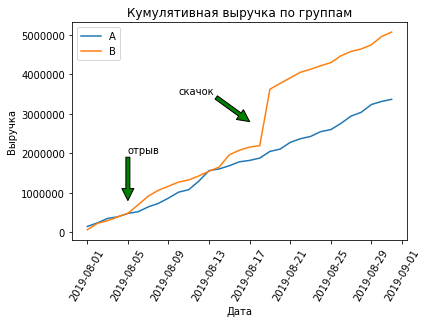

In [99]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xticks(rotation=60)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.show()

Наблюдается постоянный рост выручки. Выручка группы B превышает выручку группы А практически на всем периоде теста. Также в данных группы  B наблюдается резкий скачок выручки в один из дней - вероятно, это последствие очень крупного заказа.

### График кумулятивного среднего чека по группам

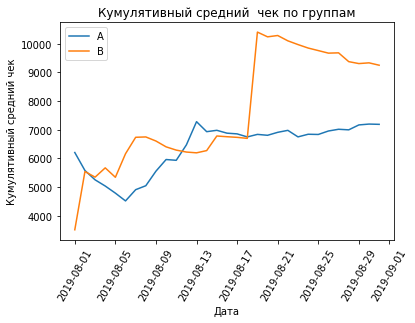

In [100]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('Кумулятивный средний  чек по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.xticks(rotation=60)
plt.show()

Исходя из графика нельзя с уверенностью сказать, в какой группе средний чек был больше -лидировала то одна, то другая группа. На последней трети графика лидирует группа B, однако это скорее последствие выброса - без него скорее всего средний чек был бы чуть выше у группы A. Для группы а в конце периода наблюдается рост, а у группы B - падение.

### График относительного изменения кумулятивного среднего чека группы B к группе A

Соберем данные по группам в одном датафрейме

In [101]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

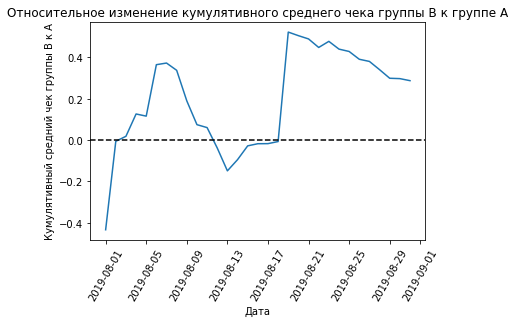

In [102]:
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек группы B к A')
plt.xticks(rotation=60)
plt.show()

На графике наблюдаются резкие скачки, вероятно в результате выбросов. 

### График кумулятивной конверсии по группам

считаем кумулятивную конверсию

In [103]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [104]:
cumulativeData['date'] = cumulativeData['date'].astype('str')

отделяем данные по группам

In [105]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


строим графики

In [106]:
cumulativeData['date'].min()

'2019-08-01'

In [107]:
cumulativeData['date'].max()

'2019-08-31'

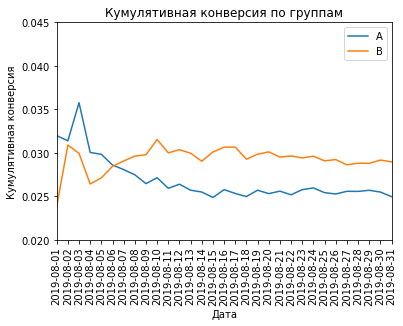

In [108]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=90)
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
# задаем масштаб осей
plt.axis(['2019-08-01', '2019-08-31', 0.02, 0.045]) 
plt.show()

Показатели конверсии достаточно быстро установились для обеих групп, притом для группы B конверсия была стабильно выше.

### График относительного изменения кумулятивной конверсии группы B к группе A

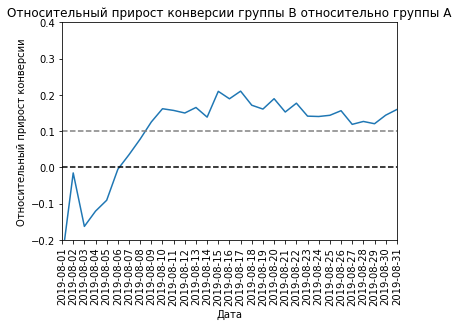

In [109]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel('Дата')
plt.ylabel('Относительный прирост конверсии')
plt.xticks(rotation=90)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(['2019-08-01', '2019-08-31', -0.2, 0.4]) 
plt.show()

В начале теста конверсия группы B была немного меньше чем в группе А, однако затем конверсия в группе B выросла и была стабильно больше, чем в группе A, приблизительно на 10%

### График количества заказов по пользователям

In [110]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsers.columns = ['visitorid', 'orders']

In [111]:
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorid,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


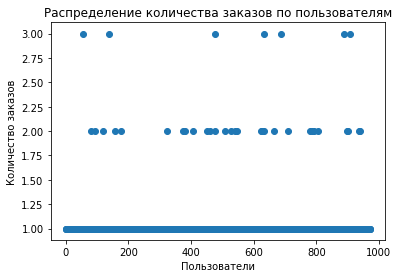

In [112]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов');

Судя по графику пользователи редко делали больше 2-х заказов

Посчитаем 95й и 99й процентили

In [113]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Аномальными значениями можно считать 3 и более заказов

### График стоимостей заказов

In [114]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

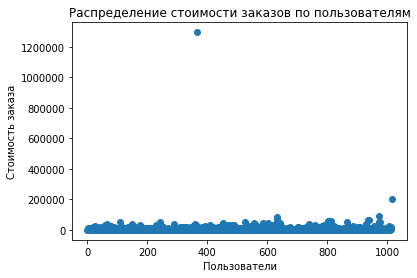

In [115]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) ;
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа');

На графике виден один заказ с суммой более 1,2 млн, также есть один явный выброс в районе 200 тысяч

Посчитаем 95й и 99й процентили


In [116]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

В качестве границы аномальных значений целесообразно принять 28000

### Cчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Посчитаем кумулятивное количество пользователей по дням

In [117]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [118]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

Посчитае кумулятивное количество и сумму заказов по дням

In [119]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [120]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [121]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [122]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [123]:
data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в конверсии между группами

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [124]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorid', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [125]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
 

Проверим гипотезу о равенстве конверсии в группах:  
Нулевая гипотеза: Конверсии в группах A и B равны.  
Альтернативная гипотеза: Конверсии в группах A и B различаются.

In [126]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


0.011
0.160


Получили p-value 0.011, меньше чем 0.05 -- отвергаем нулевую гипотезу о равенстве конверсии в группах A и B.  
Относительный выигрыш группы B равен 16%

### Считаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Проверим гипотезу о равенстве среднего чека в группах:
Нулевая гипотеза: Средний чек в группах A и B равны.
Альтернативная гипотеза: Средний чек в группах A и B различаются.

In [127]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative='two-sided')[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.829
0.287


P-value равен 0.829 и значительно превышает уровень статистической значимости в 0.05.  Мы не смогли отвергнуть нулевую гипотезу - нет причин полагать, что средний чек групп на самом деле различается. Хотя по результатам нашего теста средний чек группы B оказался выше на 28.7%

### Считаем статистическую значимость различий в конверсии между группами по «очищенным» данным

Ранее для определения аномальных показателей, мы выбрали границу в 2 заказа и сумму чека в 28000 ед. Всё, что выше этих показателей, считаем аномалиями.

In [128]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

937    148427295
792    204675465
33     249864742
586    358944393
557    382846391
Name: visitorid, dtype: int64
(55,)


По выбранным критериям аномальных показателей определили 74 пользователя

Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

In [129]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Проверим гипотезу о равенстве конверсии в группах:  
Нулевая гипотеза: Конверсии в группах A и B равны.  
Альтернативная гипотеза: Конверсии в группах A и B различаются.  
Применим статистический критерий Манна-Уитни к полученным выборкам

In [130]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative='two-sided')[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.009
0.189


Получили p-value 0.009 (было 0.011), конверсия в группе B на 18.9% больше чем в A (по "сырым" данным было 16%).  
Отвергаем нулевую гипотезу в пользу альтернативной.  
По "очищенным" данным разница в конверсии между группами стала еще большей.

### Считаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Проверим гипотезу о равенстве среднего чека в группах:  
Нулевая гипотеза: Средний чек в группах A и B равны.  
Альтернативная гипотеза: Средний чек в группах A и B различаются.

In [131]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            alternative='two-sided'
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.762
-0.022


P-value по очищенным данным, как и по "сырым", оказался намного больше 0.05 (0.762 по "очищенным" против 0.829 по "сырым"), по-прежнему нет оснований полагать что в среднем чеке по группам есть разница. Это подтверждвет и показатель разницы между группами, по "очищенным" данным он составил всего -2% (по "сырым" был почти 29%). 

### Выводы


Имеющиеся факты:  
* Нам удалось зафиксировать статистически значимое различие в конверсии между группами A и B. У группы B этот показатель стабильно выше -- исходя из графика относительного прироста конверсии группы B относительно группы A можно сказать, что в ближайшее время такое положение дел сохранится. Наблюдения совпадают и по "сырым" и по "очищенным" данным.  
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.


С учетом этих фактов можно рекомендовать остановить тест, зафиксировать победу группы B.


## Выводы
Мы провели **приоритезацию гипотез** и получили следующие результаты:  
По ICE три самые приоритетные гипотезы:  
* Запустить акцию, дающую скидку на товар в день рождения  
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  

По RICE самые приоритетные гипотезы:  
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа  
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей  
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию  
*последние две гипотезы разделили третье место *italicized text*  

Добавление формы подписки в RICE вышло на первое место с большим отрывом за счет максимального охвата пользователей, в ICE у гипотезы было 3-е место. В то же время у гипотезы о добавлении скидки на день рождения в ICE было первое место, а в RICE  лишь 5-е, при этом отрыв от 4-х более приоритетных гипотез достаточно существенный -- скидка на день рождения имеет очень малый охват пользователей.  
  
  

Также мы провели **анализ данных A/B теста**.  
По результатам можно рекомендовать остановить тест, зафиксировать победу группы B.  

В рамках анализа мы сравнили показатели конверсии посетителей в покупателей, а также показатели среднего чека по двум группам пользователей.
Имеющиеся факты: 

Нам удалось зафиксировать статистически значимое различие в конверсии между группами A и B. У группы B этот показатель стабильно выше -- исходя из графика относительного прироста конверсии группы B относительно группы A можно сказать, что в ближайшее время такое положение дел сохранится. Наблюдения совпадают и по "сырым" и по "очищенным" данным.  
Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.  
